![](itd2.png)
 
    
**Inteligencia Artificial:**
**Deteccion de anomalias en medidores de Internet**

**Nombre del docente:**
**Jose Gabriel Rodriguez Rivas**

**Nombre del alumno:**
**Vergara Hernandez Jesus Alejandro**

**Situación/Contexto
Los algoritmos de detección de anomalías ubican los puntos de datos que se destacan en un patrón. Por ejemplo, los algoritmos de este tipo se pueden utilizar para probar la seguridad de motores de aviones registrando ciertas cantidades, como consumo de combustible, temperatura, etc. Siempre que las mediciones muestren valores extremos, como alta temperatura inusual, la detección de anomalías alerta al operador, quien luego puede tomar medidas para resolver problemas potenciales. La mejora uniforme de normas de seguridad no es exclusiva del sector de transportes, y estos algoritmos encuentran aplicaciones en todas las ramas del sector, desde la elaboración de alimentos hasta la producción de juguetes para niños.**

**Parte 1: Ingeniería de funciones**

*Paso 1: Importar las bibliotecas de Python*

In [1]:
# Code Cell 1
import numpy as np
import pandas as pd

*Paso 2: Crear un marco de datos y modificar las cantidades*

In [2]:
# Load internet speed data
df = pd.read_csv('rpi_data_processed.csv')

# Initialize dataframe df_rates
df_rates = df.drop(['Ping (ms)', 'Date', 'Time'], axis=1)

# Rename the download and
# upload columns of df_rates
lookup = {'Download (Mbit/s)': 'download_rate', 
          'Upload (Mbit/s)': 'upload_rate'}
df_rates = df_rates.rename(columns = lookup)

# Calculate ping_rate
ping_rate = 1. / df['Ping (ms)']

# Convert ping_rate to 1/seconds
ping_rate = 1000. * ping_rate

# Add a column to complete the task
df_rates['ping_rate'] = ping_rate

In [3]:
# Code Cell 3
# Let us inspect the result
df_rates.describe()

,upload_rate,download_rate,ping_rate
count,673.000000,673.000000,673.000000
mean,13.697608,90.449212,48.657348
std,1.080471,3.465647,6.030512
min,6.210000,58.480000,13.067113
25%,13.640000,90.220000,45.781257
50%,13.980000,91.560000,49.207755
75%,14.180000,92.070000,52.314936
max,14.550000,92.870000,61.854395


*Paso 3: Visualizar datos*

In [4]:
# Code Cell 4
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [5]:
# Code Cell 5
def scatter_view(x, y, z, azim, elev):
    # Init figure and axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    # Compute scatter plot
    ax.scatter(x, y, z)
    ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
    ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
    ax.set_zlabel('P rate (1/s)', fontsize=16)
    
    # Specify azimuth
    # and elevation
    ax.azim = azim
    ax.elev = elev

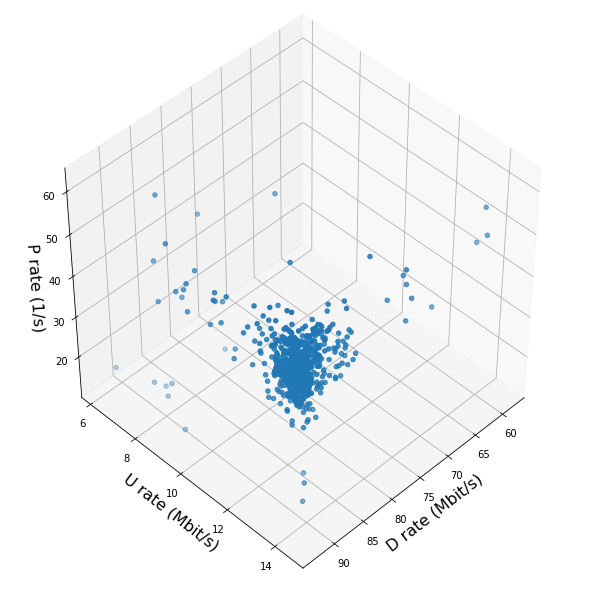

<function __main__.<lambda>(azim, elev)>

In [6]:
# Code Cell 6
# Draw interactive plot
xi = df_rates['download_rate']
yi = df_rates['upload_rate']
zi = df_rates['ping_rate']
interact(lambda azim, elev: scatter_view(xi, yi, zi, azim, elev),
         azim=(0, 90), elev=(0, 90))

**Parte 2: Detección de anomalías euclidiana**

*Paso 1: Calcular los promedios*

In [7]:
# Code Cell 7
mu = df_rates.mean()

*Paso 2: Calcular la distancia euclidiana*

In [8]:
# Code Cell 8
euclid_sq = np.square(df_rates-mu).sum(axis=1)
euclid = np.sqrt(euclid_sq)

*Paso 3: Crear un histograma*

Text(0, 0.5, 'Relative frequency')

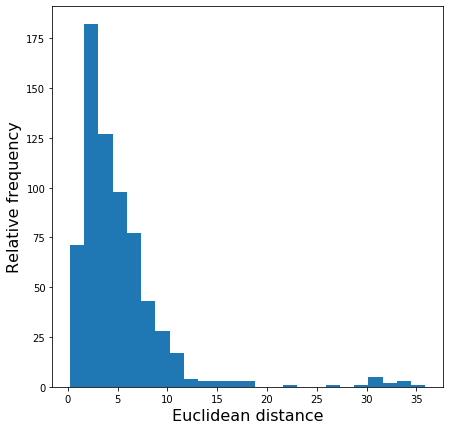

In [10]:

# Code Cell 9
# Histogram of Euclidean distance
fig = plt.figure(figsize=(7, 7))
plt.hist(euclid,25)
plt.xlabel('Euclidean distance', fontsize=16)
plt.ylabel('Relative frequency', fontsize=16)

*Paso 4: Calcular la distancia normalizada*

In [11]:
max_euclid = euclid.max() # Maximum Euclidean distance
nmd_euclid = [float (x) / max_euclid for x in euclid ] # Normalized Euclidean distance

*Paso 5: Visualizar el índice de alarmas*

In [12]:

# Code Cell 11
# Get alarm rate as a function
# of normalized decision distance
ecl_alarm_rate = []
nmd_range = np.linspace(0, 1, 400)
for nmd_decision in nmd_range:
    num_fail= (nmd_euclid>nmd_decision).sum()   
    ecl_alarm_rate.append(float (num_fail)/len(euclid))

Text(0, 0.5, 'Alarm rate')

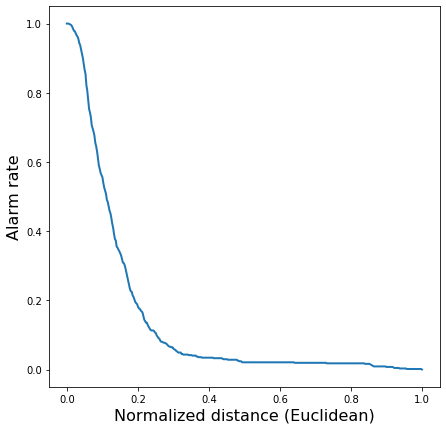

In [13]:
# Generate a suitable plot
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)

*Paso 6: Seleccionar el límite de decisión*

In [14]:

# Code Cell 13
# Select decision boundary
threshold = 0.1
index, ecl_threshold = next(tpl for tpl in enumerate(ecl_alarm_rate) if tpl[1] < threshold)
ecl_decision = nmd_range[index]

*Paso 7: Visualizar el límite de decisión*

Text(0, 0.5, 'Alarm rate')

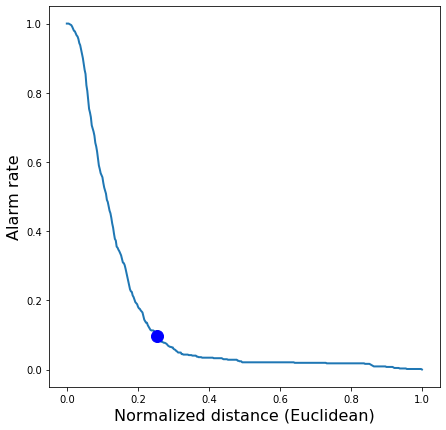

In [15]:
#Code Cell 14
# Alarm rate with decision boundary
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.plot(ecl_decision,ecl_threshold,'bo',markersize=12)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)

*Paso 8: Visualizar el límite de decisión en 3D
Debido a que nuestro algoritmo de detección de anomalías utiliza distancias euclidianas, sus límites de decisión, cuando se visualizan en tres dimensiones, son esféricos. Observe el siguiente gráfico para comprobar esto. También le sugerimos leer y comprender el código asociado.*

In [16]:
# Decision sphere (Polar coordinates)
radius = ecl_decision * max_euclid
phi = np.linspace(0, 2 * np.pi, 300)
theta = np.linspace(0, np.pi, 300)

# Decision sphere (Cartesian coordinates)
xs = radius * np.outer(np.sin(theta), np.cos(phi))
ys = radius * np.outer(np.sin(theta), np.sin(phi))
zs = radius * np.outer(np.cos(theta), np.ones(np.size(phi)))

# Centre decision sphere at mean
ecl_xd = xs + df_rates['download_rate'].mean()
ecl_yd = ys + df_rates['upload_rate'].mean()
ecl_zd = zs + df_rates['ping_rate'].mean()

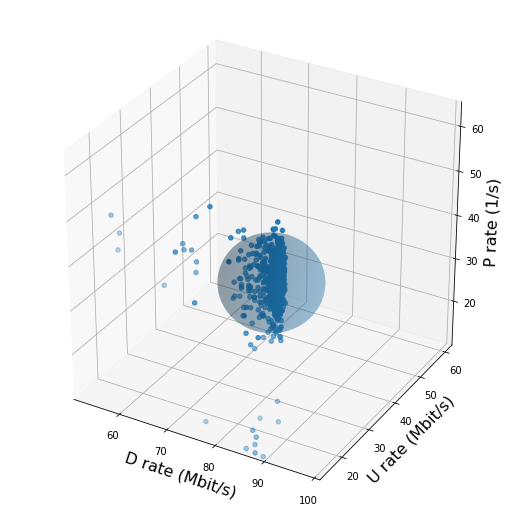

In [17]:

#Code Cell 16
# Init figure and axes
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

# Plot data
ax.scatter(df_rates['download_rate'],
           df_rates['upload_rate'], 
           df_rates['ping_rate'])

# Plot decision boundary
ax.plot_surface(ecl_xd, ecl_yd, ecl_zd,
                linewidth=0, alpha=0.25)

# Label axes
ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
ax.set_zlabel('P rate (1/s)', fontsize=16)
    
# --------------------------------------------------
# Set equal aspect ratio for all axes
# --------------------------------------------------

# Extreme values of x, y, z
extremes = []
extremes.append([df_rates['download_rate'].min(),
                 df_rates['download_rate'].max()])
extremes.append([df_rates['upload_rate'].min(),
                 df_rates['upload_rate'].max()])
extremes.append([df_rates['ping_rate'].min(),
                 df_rates['ping_rate'].max()])

# Half-widths and mid-points
hwidths = [(row[1] - row[0]) / 2.0 for row in extremes]
midpts = [(row[1] + row[0]) / 2.0 for row in extremes]

# Set xlim, ylim, zlim
left_ends = midpts - np.max(hwidths)
right_ends = midpts + np.max(hwidths)
ax.set_xlim([left_ends[0], right_ends[0]]);
ax.set_ylim([left_ends[1], right_ends[1]]);
ax.set_ylim([left_ends[2], right_ends[2]]);